# Динамічне деформування балки з проміжною опорою

In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import quad
import numpy as np
import copy

from numba import jit, cuda

## Однорідне рівняння: МПП

In [2]:
L = 10

In [3]:
def Krylov(index,varphi,s):    
    if index == 1:
        return (1.0/2)*(np.cosh(varphi*s) + np.cos(varphi*s))
    if index == 2:
        return (1.0/(2*varphi))*(np.sinh(varphi*s) + np.sin(varphi*s))
    if index == 3:
        return (1.0/(2*np.power(varphi,2)))*(np.cosh(varphi*s) - np.cos(varphi*s))
    if index == 4:
        return (1.0/(2*np.power(varphi,3)))*(np.sinh(varphi*s) - np.sin(varphi*s))

In [4]:
def solve_homogeneous_TMM(theta0,varphi):
    X = np.zeros(16)

    # beginning of element 1
    X[0] = 0
    X[1] = theta0
    X[2] = 0
    X[3] = X[1] * (-Krylov(2,varphi,L)/Krylov(4,varphi,L))

    # end of element 1
    X[4] = 0
    X[5] = X[1] * (Krylov(1,varphi,L) - Krylov(3,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))
    X[6] = X[1] * (np.power(varphi,4)*Krylov(4,varphi,L) - Krylov(2,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))
    X[7] = X[1] * (np.power(varphi,4)*Krylov(3,varphi,L) - Krylov(1,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))

    # beginning of element 2
    X[8] = 0
    X[9] = X[5]
    X[10] = X[6]
    X[11] = - X[9]*Krylov(2,varphi,L)/Krylov(4,varphi,L) - X[10]*Krylov(3,varphi,L)/Krylov(4,varphi,L)

    # end of element 2
    X[12] = 0   
    X[13] = X[9]*Krylov(1,varphi,L) + X[10]*Krylov(2,varphi,L) + X[11]*Krylov(3,varphi,L)
    X[14] = X[9]*np.power(varphi,4)*Krylov(4,varphi,L) + X[10]*Krylov(1,varphi,L) + X[11]*Krylov(2,varphi,L)
    X[15] = X[9]*np.power(varphi,4)*Krylov(3,varphi,L) + X[10]*np.power(varphi,4)*Krylov(4,varphi,L) + X[11]*Krylov(1,varphi,L)
   
    return X

### Пошук власних частот

In [5]:
step = 1e-4
w_candidates = np.arange(step, 1+step/2, step)

M2L = np.zeros(len(w_candidates))
theta0 = 1.0

w_zero_M2L = []
for i in range(len(w_candidates)):
    varphi = np.sqrt(w_candidates[i])
    X = solve_homogeneous_TMM(theta0,varphi)
    M2L[i] = X[14]

    if M2L[i] == 0:
        w_zero_M2L.append(w_candidates[i])

w_near_zero_M2L = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(M2L[i] - 0) < np.abs(M2L[i-1] - 0) and np.abs(M2L[i] - 0) < np.abs(M2L[i+1] - 0)
]
near_zero_M2L = [
    M2L[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(M2L[i] - 0) < np.abs(M2L[i-1] - 0) and np.abs(M2L[i] - 0) < np.abs(M2L[i+1] - 0)
]

print("w_zero_M2L:", w_zero_M2L)
print("w_near_zero_M2L :", w_near_zero_M2L)
print("near_zero_M2L   :", near_zero_M2L)

w_zero_M2L: []
w_near_zero_M2L : [0.09870000000000001, 0.1542, 0.3948, 0.4996, 0.8883]
near_zero_M2L   : [-7.911471201960119e-05, 0.00033948043684173257, -0.00031644274166353625, -0.0009743919376887789, -0.0007119506140043086]


In [6]:
print("Max deviation of M2L:", max(near_zero_M2L))

Max deviation of M2L: 0.00033948043684173257


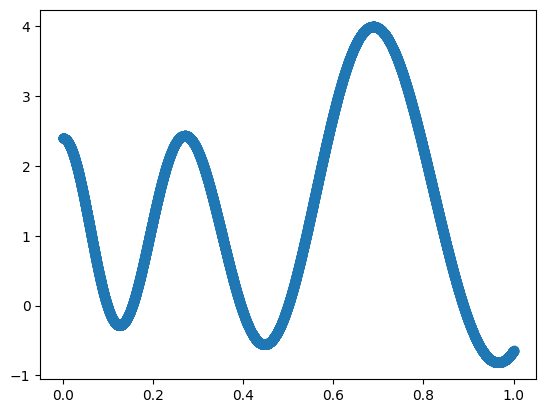

In [7]:
plt.plot(w_candidates, M2L, "o", linestyle="none")
# plt.ylim(-1,1)
plt.show()

In [8]:
# print("n w M2L")
# for i in range(len(w_candidates)):
#     print(i, w_candidates[i], M2L[i], end="\n")

### Пошук власних форм

In [9]:
w_1 = w_near_zero_M2L[0]
w_2 = w_near_zero_M2L[1]
w_3 = w_near_zero_M2L[2]
w_4 = w_near_zero_M2L[3]
w_5 = w_near_zero_M2L[4]

tmm_w = [w_1,w_2,w_3,w_4,w_5]

In [10]:
W_tmm = []

for w_i in tmm_w:
    varphi = np.sqrt(w_i)
    X = solve_homogeneous_TMM(theta0,varphi)

    print(f"\nw = {w_i}")
    print(f"W(s) = K2 + {X[3]}*K4, s in [0,L]")
    print(f"W(s) = {X[9]}*K2 + {X[10]}*K3 + {X[11]}*K4, s in [L,2L]")

    step = 0.01
    S = np.arange(0, 2*L+step/2, step)
    W_i = []

    for s in S:
        if 0 <= s <= L:
            W_i.append(X[1]*Krylov(2,varphi,s) + X[3]*Krylov(4,varphi,s))
        if L < s <= 2*L:
            W_i.append(X[9]*Krylov(2,varphi,s-L) + X[10]*Krylov(3,varphi,s-L) + X[11]*Krylov(4,varphi,s-L))
    
    W_tmm.append(copy.deepcopy(W_i))


w = 0.09870000000000001
W(s) = K2 + -0.09869892389754653*K4, s in [0,L]
W(s) = -0.9999313505291525*K2 + 3.9560071787958506e-05*K3 + 0.0986785973282282*K4, s in [L,2L]

w = 0.1542
W(s) = K2 + -0.14583651395664965*K4, s in [0,L]
W(s) = 0.0003142225461658654*K2 + 0.5401910858768959*K3 + -0.21233190668526486*K4, s in [L,2L]

w = 0.3948
W(s) = K2 + -0.3948003713063018*K4, s in [0,L]
W(s) = 0.9998745395986361*K2 + -0.0001582412238434472*K3 + -0.39465178217380464*K4, s in [L,2L]

w = 0.4996
W(s) = K2 + -0.5008046035721684*K4, s in [0,L]
W(s) = 0.00048697195342128907*K2 + -1.0004600170427693*K3 + 0.7069055945097764*K4, s in [L,2L]

w = 0.8883
W(s) = K2 + -0.8882999458497244*K4, s in [0,L]
W(s) = -0.9998110690130488*K2 + 0.0003560425743671658*K3 + 0.8877964953740061*K4, s in [L,2L]


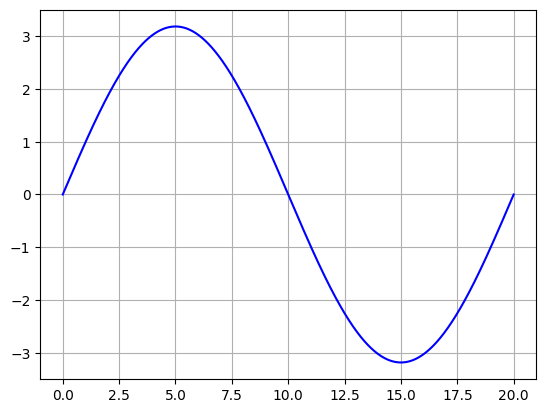

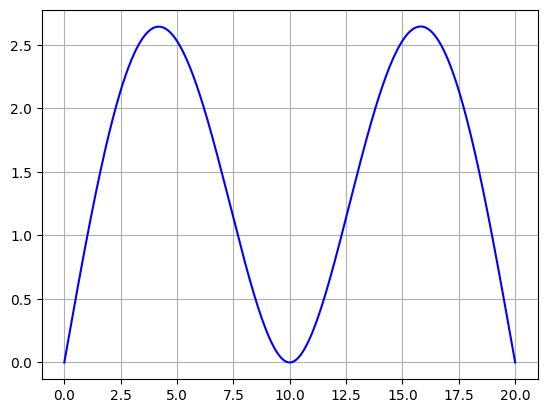

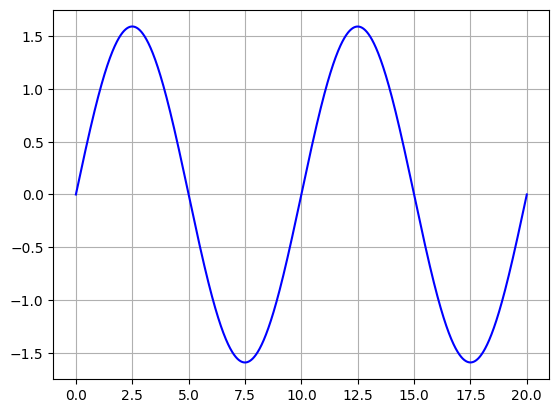

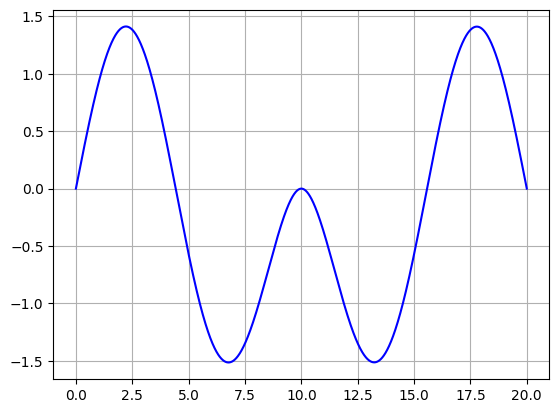

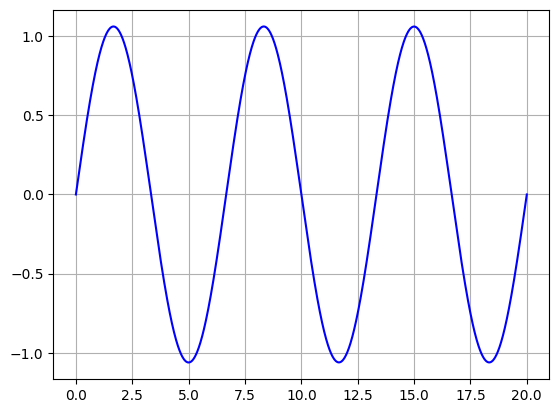

In [11]:
for i in range(len(W_tmm)):
    plt.plot(S, W_tmm[i], color='blue')
    plt.grid()
    plt.show()

In [12]:
# print("n s W(s)")
# for i in range(len(S)):
#     print(f"{i} {S[i]} {W_tmm[4][i]}")

## Однорідне рівняння: МЗЗ

Набір з $M=5$ базових функцій експоненціальної сім'ї:
\begin{align*}
    & \phi_1(s) = e^{-\frac{4s}{2L}} + A_{11}e^{-\frac{3s}{2L}} + A_{12}e^{-\frac{2s}{2L}} + A_{13}e^{-\frac{s}{2L}} + A_{14} \\
    & \phi_2(s) = e^{-\frac{3s}{2L}} + A_{21}e^{-\frac{2s}{2L}} + A_{22}e^{-\frac{s}{2L}} + A_{23} + A_{24}e^{\frac{s}{2L}} \\
    & \phi_3(s) = e^{-\frac{2s}{2L}} + A_{21}e^{-\frac{s}{2L}} + A_{22} + A_{23}e^{\frac{s}{2L}} + A_{24}e^{\frac{2s}{2L}} \\
    & \phi_4(s) = e^{-\frac{s}{2L}} + A_{21} + A_{22}e^{\frac{s}{2L}} + A_{23}e^{\frac{2s}{2L}} + A_{24}e^{\frac{3s}{2L}} \\
    & \phi_5(s) = 1 + A_{21}e^{\frac{s}{2L}} + A_{22}e^{\frac{2s}{2L}} + A_{23}e^{\frac{3s}{2L}} + A_{24}e^{\frac{4s}{2L}}
\end{align*}

### МЗЗ з двома базовими функціями

#### Задовільнення граничним умовам

In [13]:
A1 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-3), np.exp(-2), np.exp(-1), 1],
    [9, 4, 1, 0],
    [9*np.exp(-3), 4*np.exp(-2), np.exp(-1), 0],
])

B1 = np.array([-1, -np.exp(-4), -16, -16*np.exp(-4)])

A1_inv = np.linalg.inv(A1)
a1, b1, c1, d1 = np.dot(A1_inv,B1)

A2 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-2), np.exp(-1), 1, np.exp(1)],
    [4, 1, 0, 1],
    [4*np.exp(-2), np.exp(-1), 0, np.exp(1)],
])

B2 = np.array([-1, -np.exp(-3), -9, -9*np.exp(-3)])

A2_inv = np.linalg.inv(A2)
a2, b2, c2, d2 = np.dot(A2_inv,B2)

In [14]:
def phi_1(x):
    return np.exp(-(4*x)/(2*L)) + a1*np.exp(-(3*x)/(2*L)) + b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L)) + d1

def d4_phi_1(x):
    return (256*np.exp(-(4*x)/(2*L)) + 81*a1*np.exp(-(3*x)/(2*L)) + 16*b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L))) / (16*L**4)

def phi_2(x):
    return np.exp(-(3*x)/(2*L)) + a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + c2 + d2*np.exp(x/(2*L))

def d4_phi_2(x):
    return (81*np.exp(-(3*x)/(2*L)) + 16*a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + d2*np.exp(x/(2*L))) / (16*L**4)

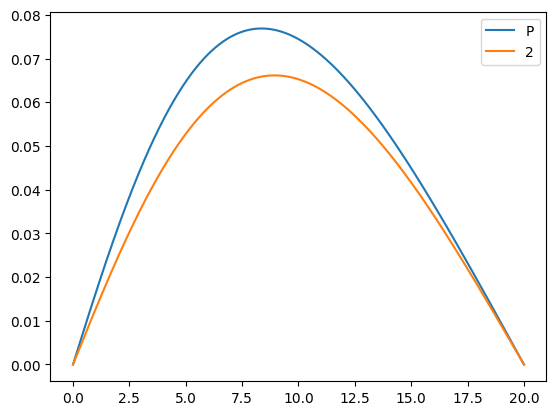

In [15]:
step = 0.01
S = np.arange(0, 2*L+step/2, step)

plt.plot(S,[phi_1(x) for x in S])
plt.legend("P1")

plt.plot(S,[phi_2(x) for x in S])
plt.legend("P2")
plt.show()

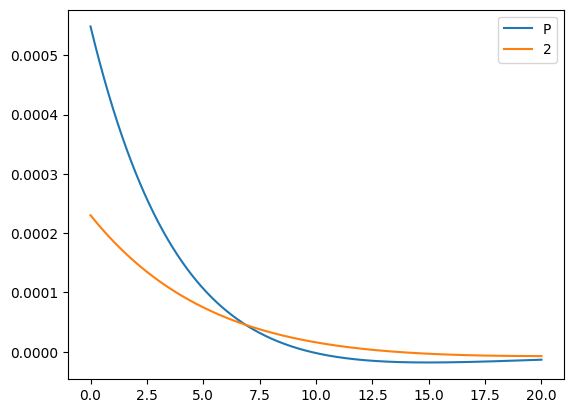

In [16]:
step = 0.01
S = np.arange(0, 2*L+step/2, step)

plt.plot(S,[d4_phi_1(x) for x in S])
plt.legend("P1")

plt.plot(S,[d4_phi_2(x) for x in S])
plt.legend("P2")
plt.show()

In [17]:
def integrand_11(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_1(x))

def integrand_21(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_1(x))

def integrand_12(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_2(x))

def integrand_22(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_2(x))

In [18]:
def calculate_integrads_2(w):
    I = np.zeros((3,3))

    I[1][1] = quad(integrand_11, 0, 2*L, args=w)[0]
    I[2][1] = quad(integrand_21, 0, 2*L, args=w)[0]
    I[1][2] = quad(integrand_12, 0, 2*L, args=w)[0]
    I[2][2] = quad(integrand_22, 0, 2*L, args=w)[0]

    return I

### Пошук власних частот

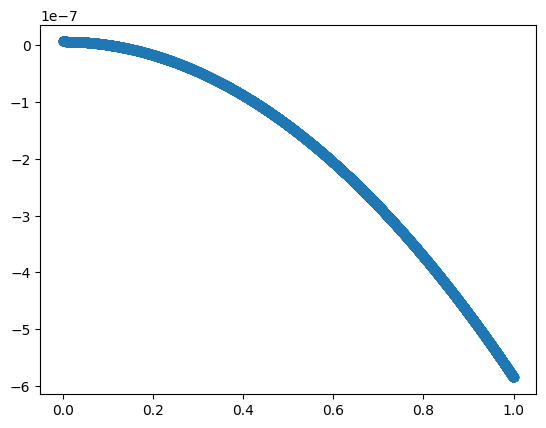

In [19]:
step = 1e-4
w_candidates = np.arange(0, 1+step/2, step)
determinant = np.zeros(len(w_candidates))

w_zero_determinant = []
for i in range(len(w_candidates)):
    I = calculate_integrads_2(w_candidates[i])

    U = np.array([
        [I[1][1], I[2][1], -phi_1(L)], 
        [I[1][2], I[2][2], -phi_2(L)],
        [phi_1(L), phi_2(L), 0]
    ])

    determinant[i] = np.linalg.det(U)
    if determinant[i] == 0:
        w_zero_determinant.append(w_candidates[i])

plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.show()

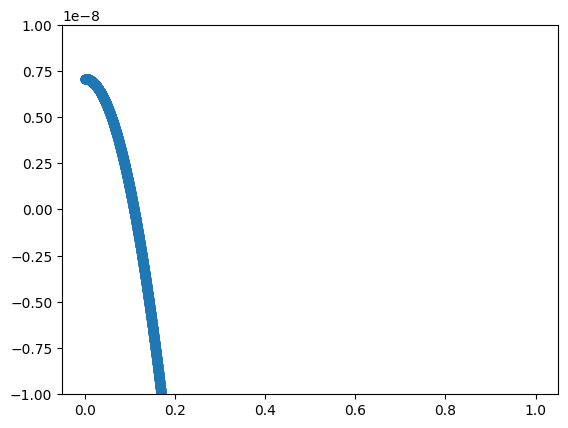

In [20]:
plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.ylim(-1e-8, 1e-8)
# plt.xlim(0,0.2)
plt.show()

In [21]:
w_near_zero_determinant = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

near_zero_determinant = [
    determinant[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

print("w_near_zero_determinant :", w_near_zero_determinant)
print("near_zero_determinant   :", near_zero_determinant)

w_near_zero_determinant : [0.10930000000000001]
near_zero_determinant   : [3.047304327518632e-12]


In [22]:
# print("n w det")
# for i in range(len(w_candidates)):
#     print(f"{i} {w_candidates[i]} {determinant[i]}")

### Пошук власних форм

In [23]:
I = calculate_integrads_2(w_near_zero_determinant[0])
alpha1 = 1000

U = np.array([
    [I[2][1], -phi_1(L)], 
    # [I[2][2], -phi_2(L)],
    [phi_2(L), 0]
])

V = np.array([-alpha1*I[1][1], -alpha1*phi_1(L)])

U_inv = np.linalg.inv(U)
alpha2, Z = np.dot(U_inv,V)

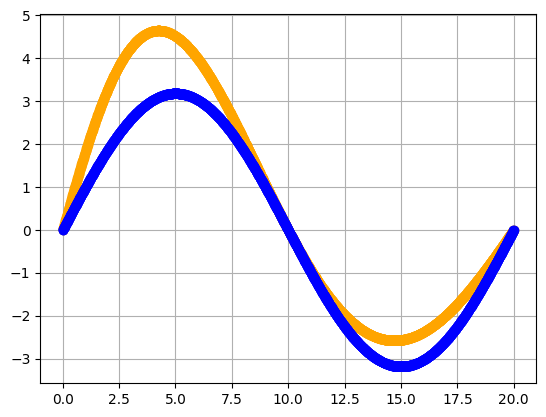

In [24]:
step = 0.01
S_wrm = np.arange(0, 2*L+step/2, step)
W_wrm_2 = np.array([alpha1*phi_1(s) + alpha2*phi_2(s) for s in S_wrm])

plt.plot(S_wrm, W_wrm_2, marker="o", color="orange")
plt.plot(S_wrm, W_tmm[0], marker="o", color="blue")
plt.grid()
plt.show()

In [25]:
# print("n s W(s)")
# for i in range(len(S_wrm)):
#     print(f"{i} {S_wrm[i]} {W_wrm_2[i]}")

### МЗЗ з п'ятьма базовими функціями

#### Задовільнення граничним умовам

In [26]:
A1 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-3), np.exp(-2), np.exp(-1), 1],
    [9, 4, 1, 0],
    [9*np.exp(-3), 4*np.exp(-2), np.exp(-1), 0],
])

B1 = np.array([-1, -np.exp(-4), -16, -16*np.exp(-4)])

A1_inv = np.linalg.inv(A1)
a1, b1, c1, d1 = np.dot(A1_inv,B1)

A2 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-2), np.exp(-1), 1, np.exp(1)],
    [4, 1, 0, 1],
    [4*np.exp(-2), np.exp(-1), 0, np.exp(1)],
])

B2 = np.array([-1, -np.exp(-3), -9, -9*np.exp(-3)])

A2_inv = np.linalg.inv(A2)
a2, b2, c2, d2 = np.dot(A2_inv,B2)

A3 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-1), 1, np.exp(1), np.exp(2)],
    [1, 0, 1, 4],
    [np.exp(-1), 0, np.exp(1), 4*np.exp(2)],
])

B3 = np.array([-1, -np.exp(-2), -4, -4*np.exp(-2)])

A3_inv = np.linalg.inv(A3)
a3, b3, c3, d3 = np.dot(A3_inv,B3)

A4 = np.array([
    [1, 1, 1, 1], 
    [1, np.exp(1), np.exp(2), np.exp(3)],
    [0, 1, 4, 9],
    [0, np.exp(1), 4*np.exp(2), 9*np.exp(3)],
])

B4 = np.array([-1, -np.exp(-1), -1, -np.exp(-1)])

A4_inv = np.linalg.inv(A4)
a4, b4, c4, d4 = np.dot(A4_inv,B4)

A5 = np.array([
    [1, 1, 1, 1], 
    [np.exp(1), np.exp(2), np.exp(3), np.exp(4)],
    [1, 4, 9, 16],
    [np.exp(1), 4*np.exp(2), 9*np.exp(3), 16*np.exp(4)],
])

B5 = np.array([-1, -1, 0, 0])

A5_inv = np.linalg.inv(A5)
a5, b5, c5, d5 = np.dot(A5_inv,B5)

In [27]:
def phi_1(x):
    return np.exp(-(4*x)/(2*L)) + a1*np.exp(-(3*x)/(2*L)) + b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L)) + d1

def d4_phi_1(x):
    return (256*np.exp(-(4*x)/(2*L)) + 81*a1*np.exp(-(3*x)/(2*L)) + 16*b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L))) / (16*L**4)

def phi_2(x):
    return np.exp(-(3*x)/(2*L)) + a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + c2 + d2*np.exp(x/(2*L))

def d4_phi_2(x):
    return (81*np.exp(-(3*x)/(2*L)) + 16*a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + d2*np.exp(x/(2*L))) / (16*L**4)

def phi_3(x):
    return np.exp(-(2*x)/(2*L)) + a3*np.exp(-x/(2*L)) + b3 + c3*np.exp(x/(2*L)) + d3*np.exp((2*x)/(2*L))

def d4_phi_3(x):
    return (16*np.exp(-(2*x)/(2*L)) + a3*np.exp(-x/(2*L)) + c3*np.exp(x/(2*L)) + 16*d3*np.exp((2*x)/(2*L))) / (16*L**4)

def phi_4(x):
    return np.exp(-x/(2*L)) + a4 + b4*np.exp(x/(2*L)) + c4*np.exp((2*x)/(2*L)) + d4*np.exp((3*x)/(2*L))

def d4_phi_4(x):
    return (np.exp(-x/(2*L)) + b4*np.exp(x/(2*L)) + 16*c4*np.exp((2*x)/(2*L)) + 81*d4*np.exp((3*x)/(2*L))) / (16*L**4)

def phi_5(x):
    return 1 + a5*np.exp(x/(2*L)) + b5*np.exp((2*x)/(2*L)) + c5*np.exp((3*x)/(2*L)) + d5*np.exp((4*x)/(2*L))

def d4_phi_5(x):
    return (a5*np.exp(x/(2*L)) + 16*b5*np.exp((2*x)/(2*L)) + 81*c5*np.exp((3*x)/(2*L)) + 256*d5*np.exp((4*x)/(2*L))) / (16*L**4)

In [28]:
def integrand_11(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_1(x))

def integrand_21(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_1(x))

def integrand_31(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_1(x))

def integrand_41(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_1(x))

def integrand_51(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_1(x))

def integrand_12(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_2(x))

def integrand_22(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_2(x))

def integrand_32(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_2(x))

def integrand_42(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_2(x))

def integrand_52(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_2(x))

def integrand_13(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_3(x))

def integrand_23(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_3(x))

def integrand_33(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_3(x))

def integrand_43(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_3(x))

def integrand_53(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_3(x))

def integrand_14(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_4(x))

def integrand_24(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_4(x))

def integrand_34(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_4(x))

def integrand_44(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_4(x))

def integrand_54(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_4(x))

def integrand_15(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_5(x))

def integrand_25(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_5(x))

def integrand_35(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_5(x))

def integrand_45(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_5(x))

def integrand_55(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_5(x))

In [29]:
def calculate_integrads(w):
    I = np.zeros((6,6))

    I[1][1] = quad(integrand_11, 0, 2*L, args=w)[0]
    I[2][1] = quad(integrand_21, 0, 2*L, args=w)[0]
    I[3][1] = quad(integrand_31, 0, 2*L, args=w)[0]
    I[4][1] = quad(integrand_41, 0, 2*L, args=w)[0]
    I[5][1] = quad(integrand_51, 0, 2*L, args=w)[0]

    I[1][2] = quad(integrand_12, 0, 2*L, args=w)[0]
    I[2][2] = quad(integrand_22, 0, 2*L, args=w)[0]
    I[3][2] = quad(integrand_32, 0, 2*L, args=w)[0]
    I[4][2] = quad(integrand_42, 0, 2*L, args=w)[0]
    I[5][2] = quad(integrand_52, 0, 2*L, args=w)[0]

    I[1][3] = quad(integrand_13, 0, 2*L, args=w)[0]
    I[2][3] = quad(integrand_23, 0, 2*L, args=w)[0]
    I[3][3] = quad(integrand_33, 0, 2*L, args=w)[0]
    I[4][3] = quad(integrand_43, 0, 2*L, args=w)[0]
    I[5][3] = quad(integrand_53, 0, 2*L, args=w)[0]

    I[1][4] = quad(integrand_14, 0, 2*L, args=w)[0]
    I[2][4] = quad(integrand_24, 0, 2*L, args=w)[0]
    I[3][4] = quad(integrand_34, 0, 2*L, args=w)[0]
    I[4][4] = quad(integrand_44, 0, 2*L, args=w)[0]
    I[5][4] = quad(integrand_54, 0, 2*L, args=w)[0]

    I[1][5] = quad(integrand_15, 0, 2*L, args=w)[0]
    I[2][5] = quad(integrand_25, 0, 2*L, args=w)[0]
    I[3][5] = quad(integrand_35, 0, 2*L, args=w)[0]
    I[4][5] = quad(integrand_45, 0, 2*L, args=w)[0]
    I[5][5] = quad(integrand_55, 0, 2*L, args=w)[0]

    return I

In [30]:
# print("n s phi1 d4_phi1 phi2 d4_phi2 phi3 phi4 phi5")
# for i in range(len(S)):
#     print(f"{i} {S[i]} {phi_1(S[i])} {d4_phi_1(S[i])} {phi_2(S[i])} {d4_phi_2(S[i])} {phi_3(S[i])} {phi_4(S[i])} {phi_5(S[i])}")

### Пошук власних частот

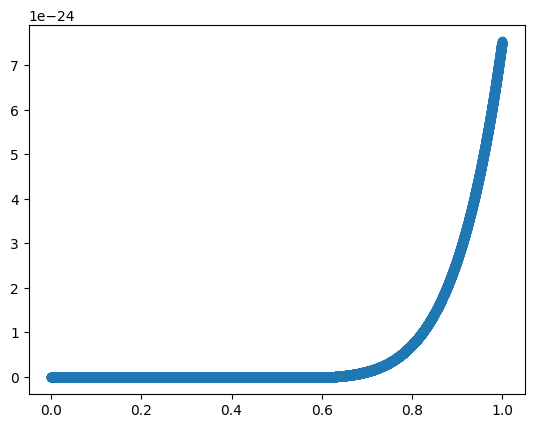

In [31]:
step = 1e-4
w_candidates = np.arange(0, 1+step/2, step)
determinant = np.zeros(len(w_candidates))

w_zero_determinant = []
for i in range(len(w_candidates)):
    I = calculate_integrads(w_candidates[i])

    U = np.array([
        [I[1][1], I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
        [I[1][2], I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
        [I[1][3], I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
        [I[1][4], I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
        [I[1][5], I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
        [phi_1(L), phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0]
    ])

    determinant[i] = np.linalg.det(U)
    if determinant[i] == 0:
        w_zero_determinant.append(w_candidates[i])

plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.show()

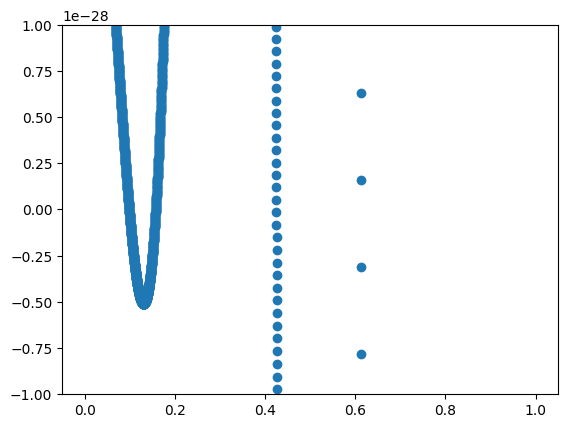

In [32]:
plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.ylim(-1e-28, 1e-28)
# plt.xlim(0, 0.3)
plt.show()

In [33]:
w_near_zero_determinant = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

near_zero_determinant = [
    determinant[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

print("w_near_zero_determinant :", w_near_zero_determinant)
print("near_zero_determinant   :", near_zero_determinant)

# w_near_zero_determinant : [0.09870000000000001, 0.15760000000000002, 0.4253, 0.6132000000000001]
# near_zero_determinant   : [1.5911698675322045e-32, 7.676663481929845e-32, -1.582870080726748e-30, 1.5750385299132378e-29]

w_near_zero_determinant : [0.09870000000000001, 0.15760000000000002, 0.4253, 0.6132000000000001]
near_zero_determinant   : [1.5911698675322045e-32, 7.676663481929845e-32, -1.582870080726748e-30, 1.5750385299132378e-29]


In [34]:
# print("n w det")
# for i in range(len(w_candidates)):
#     print(f"{i} {w_candidates[i]} {determinant[i]}")

In [35]:
# print("n w det")
# for i in range(len(w_candidates)):
#     if -1.2e-28 < determinant[i] < 1.2e-28:
#         print(f"{i} {w_candidates[i]} {determinant[i]}")

### Пошук власних форм

In [36]:
Form = 2

I = calculate_integrads(w_near_zero_determinant[Form-1])
alpha1 = -12000

U = np.array([
    [I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
    [I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
    [I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
    [I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
    # [I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
    [phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0],
])

V = np.array([-alpha1*I[1][1], -alpha1*I[1][2], -alpha1*I[1][3], -alpha1*I[1][4], -alpha1*phi_1(L)])

U_inv = np.linalg.inv(U)
alpha2, alpha3, alpha4, alpha5, Z = np.dot(U_inv,V)

In [37]:
step = 0.01
S_wrm = np.arange(0, 2*L+step/2, step)

W_wrm_5 = np.array([alpha1*phi_1(s) + alpha2*phi_2(s) + alpha3*phi_3(s) + alpha4*phi_4(s) + alpha5*phi_5(s) for s in S_wrm])

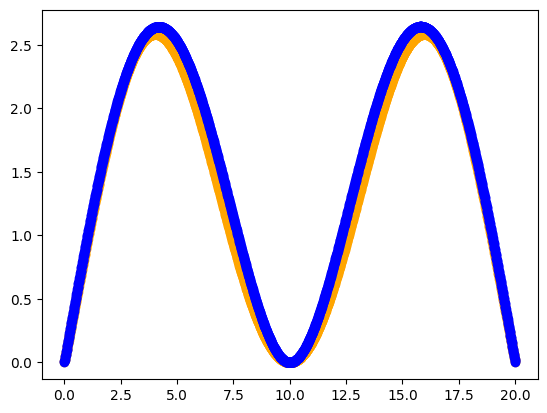

In [38]:
plt.plot(S_wrm,W_wrm_5,marker='o',color='orange')
plt.grid()

plt.plot(S_wrm,W_tmm[Form-1],marker='o',color='blue')
plt.grid()

plt.show()

### Обчислення відмінностей між формами за МПП та за МЗЗ

In [53]:
error_abs = np.array([
    abs((W_wrm_5[i]-W_tmm[Form-1][i])/W_tmm[Form-1][i]) for i in range(len(S_wrm)) if W_tmm[Form-1][i] != 0.0]
)

deviations = np.where(error_abs > 1)[0]
print(f"Deviations: {deviations}" if len(np.where(error_abs > 1)[0]) > 0 else "Zero deviations")
error = np.mean(np.delete(error_abs, deviations))

print(f"\nВідносна похибка обчсилень: {round(error*100,4)}%")

Zero deviations

Відносна похибка обчсилень: 10.8335%


In [40]:
# print("n s W(s)")
# for i in range(len(S_wrm)):
#     print(f"{i} {S[i]} {W_wrm_5[i]}")

## Неоднорідне рівняння: МПП класичний підхід

In [78]:
def define_inhomogeneous_matrices(varphi):
    A = np.zeros((16,16))
    B = np.zeros((16))

    # field equations 1
    s = L
    A[0][4], A[0][0], A[0][1], A[0][2], A[0][3], B[0] = 1, -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s), -Krylov(4,varphi,s), -Krylov(4,varphi,s-L/2)
    A[1][5], A[1][0], A[1][1], A[1][2], A[1][3], B[1] = 1, -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s), -Krylov(3,varphi,s-L/2)
    A[2][6], A[2][0], A[2][1], A[2][2], A[2][3], B[2] = 1, -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(2,varphi,s-L/2)
    A[3][7], A[3][0], A[3][1], A[3][2], A[3][3], B[3] = 1, -pow(varphi,4)*Krylov(2,varphi,s), -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(1,varphi,s-L/2)

    # edge equations left
    A[4][0] = 1
    A[5][2] = 1

    # transition equations 1-2
    A[6][8], A[6][4] = 1, -1
    A[7][9], A[7][5] = 1, -1
    A[8][10], A[8][6] = 1, -1
    A[9][4] = 1

    # field equations 2
    s = 2*L
    A[10][12], A[10][8], A[10][9], A[10][10], A[10][11] = 1, -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s), -Krylov(4,varphi,s)
    A[11][13], A[11][8], A[11][9], A[11][10], A[11][11] = 1, -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s)
    A[12][14], A[12][8], A[12][9], A[12][10], A[12][11] = 1, -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s)
    A[13][15], A[13][8], A[13][9], A[13][10], A[13][11] = 1, -pow(varphi,4)*Krylov(2,varphi,s), -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s)

    # edge equations right
    A[14][12] = 1
    A[15][14] = 1

    return A, B

### Пошук резонансних частот

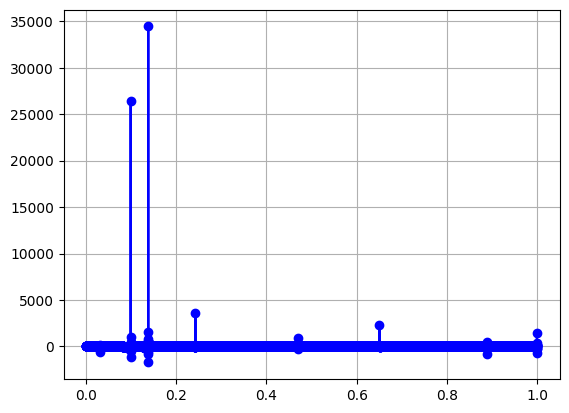

In [140]:
t = 0
s = 1

step = 1e-4
eta_candidates = np.arange(step, 1+step/2, step)
W_tmm_classic = np.zeros(len(eta_candidates))

for i in range(len(eta_candidates)):
    varphi = np.sqrt(eta_candidates[i])

    A, B = define_inhomogeneous_matrices(varphi)
    A_inv = np.linalg.inv(A)
    X = np.dot(A_inv,B)

    W_tmm_classic[i] = (X[1]*Krylov(2,varphi,s) + X[3]*Krylov(4,varphi,s)) * np.cos(eta_candidates[i]*t)
    
plt.plot(eta_candidates, W_tmm_classic, marker="o", color="blue")
plt.grid()
plt.show()

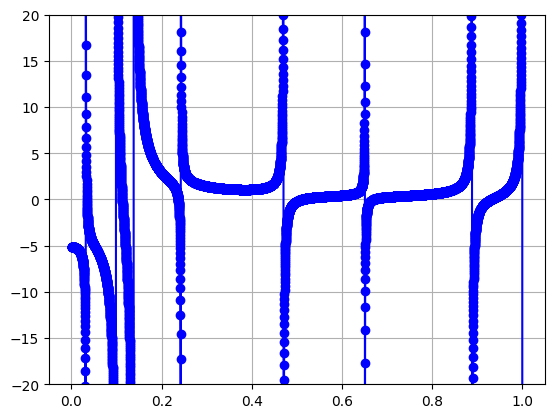

In [141]:
plt.plot(eta_candidates, W_tmm_classic, marker="o", color="blue")
plt.ylim(-20,20)
plt.grid()
plt.show()

In [142]:
eta_tmm_classic_resonant = [
    eta_candidates[i] for i in range(1,len(eta_candidates)-1) 
    if W_tmm_classic[i] == min([W_tmm_classic[i-1], W_tmm_classic[i], W_tmm_classic[i+1]])
]

print("TMM classic eta resonant:", eta_tmm_classic_resonant)

TMM classic eta resonant: [0.0316, 0.09860000000000001, 0.1379, 0.2424, 0.3847, 0.4702, 0.6507000000000001, 0.8883, 0.9997]


In [ ]:
# print("eta W_tmm_classic")
# for i in range(len(eta_candidates)):
#     if -25 < W_tmm_classic[i] < 25:
#         print(eta_candidates[i], W_tmm_classic[i])

## Неоднорідне рівняння: МПП розклад за власними формами

In [144]:
def F(x,element,varphi):
    X = solve_homogeneous_TMM(theta0,varphi)

    if element == 1:
        return X[1]*Krylov(2,varphi,x) + X[3]*Krylov(4,varphi,x) 
    if element == 2:
        return X[9]*Krylov(2,varphi,x) + X[10]*Krylov(3,varphi,x) + X[11]*Krylov(4,varphi,x)

In [145]:
def integrand_norma(x,element,varphi):
    return F(x,element,varphi)*F(x,element,varphi)

In [146]:
def T(t,element,w,eta):
    varphi = np.sqrt(w)
    
    return (F(L/2,element,varphi) / quad(integrand_norma, 0, L, args=(element,varphi))[0] / (w**2 - eta**2)) * np.cos(eta*t)

### Пошук резонансних частот

/tmp/ipykernel_14011/1922880767.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return (F(L/2,element,varphi) / quad(integrand_norma, 0, L, args=(element,varphi))[0] / (w**2 - eta**2)) * np.cos(eta*t)


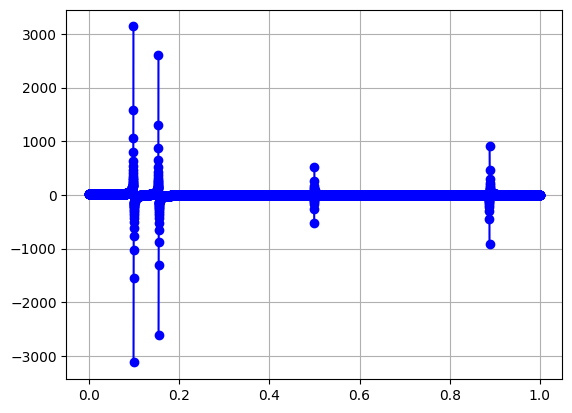

In [157]:
t = 0
s = 1

step = 1e-4
eta_candidates = np.arange(step, 1+step/2, step)
W_tmm_eigenvectors = np.zeros(len(eta_candidates))

for i in range(len(eta_candidates)):
    for w_i in tmm_w[0:5]:
        varphi = np.sqrt(w_i)
        W_tmm_eigenvectors[i] += F(s,1,varphi)*T(t,1,w_i,eta_candidates[i])
        
plt.plot(eta_candidates, W_tmm_eigenvectors, marker="o", color="blue")
plt.grid()
plt.show()

In [158]:
eta_tmm_eigenvectors_resonant = [
    eta_candidates[i] for i in range(1,len(eta_candidates)-1) 
    if W_tmm_eigenvectors[i] == min([W_tmm_eigenvectors[i-1], W_tmm_eigenvectors[i], W_tmm_eigenvectors[i+1]])
]

print("TMM eigenvectors eta resonant:", eta_tmm_eigenvectors_resonant)

TMM eigenvectors eta resonant: [0.09880000000000001, 0.1543, 0.3948, 0.4996, 0.8883]


In [ ]:
# print("eta W_tmm_eigenvectors")
# for i in range(len(eta_candidates)):
#     if -25 < W_tmm_eigenvectors[i] < 25:
#         print(eta_candidates[i], W_tmm_eigenvectors[i])

## Неоднорідне рівняння: МЗЗ

### Пошук резонансних частот

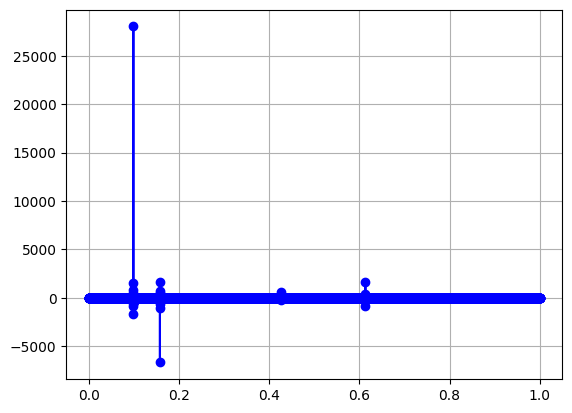

In [167]:
t = 0
s = 1

step = 1e-4
eta_candidates = np.arange(step, 1+step/2, step)
W_wrm = np.zeros(len(eta_candidates))

for i in range(len(eta_candidates)):
    I = calculate_integrads(eta_candidates[i])

    U = np.array([
        [I[1][1], I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
        [I[1][2], I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
        [I[1][3], I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
        [I[1][4], I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
        [I[1][5], I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
        [phi_1(L), phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0],
    ])

    V = np.array([
        phi_1(L/2)*np.cos(eta_candidates[i]*t) / np.cos(eta_candidates[i]*t), 
        phi_2(L/2)*np.cos(eta_candidates[i]*t) / np.cos(eta_candidates[i]*t),
        phi_3(L/2)*np.cos(eta_candidates[i]*t) / np.cos(eta_candidates[i]*t),
        phi_4(L/2)*np.cos(eta_candidates[i]*t) / np.cos(eta_candidates[i]*t),
        phi_5(L/2)*np.cos(eta_candidates[i]*t) / np.cos(eta_candidates[i]*t),
        0
    ])

    U_inv = np.linalg.inv(U)
    alpha1, alpha2, alpha3, alpha4, alpha5, Z = np.dot(U_inv,V)

    W_wrm[i] = alpha1*phi_1(s) + alpha2*phi_2(s) + alpha3*phi_3(s) + alpha4*phi_4(s) + alpha5*phi_5(s)
        
plt.plot(eta_candidates, W_wrm, marker="o", color="blue")
plt.grid()
plt.show()

In [168]:
eta_wrm_resonant = [
    eta_candidates[i] for i in range(1,len(eta_candidates)-1) 
    if W_wrm[i] == min([W_wrm[i-1], W_wrm[i], W_wrm[i+1]])
]

print("WRM eta resonant:", eta_wrm_resonant)

WRM eta resonant: [0.09880000000000001, 0.1576, 0.4252, 0.6131]


In [ ]:
# print("eta W_wrm")
# for i in range(len(eta_candidates)):
#     if -25 < W_wrm[i] < 25:
#         print(eta_candidates[i], W_wrm[i])

## Неоднорідне рівняння: порівняння кривих деформування МЗЗ та МПП

#### МПП (класичний підхід)

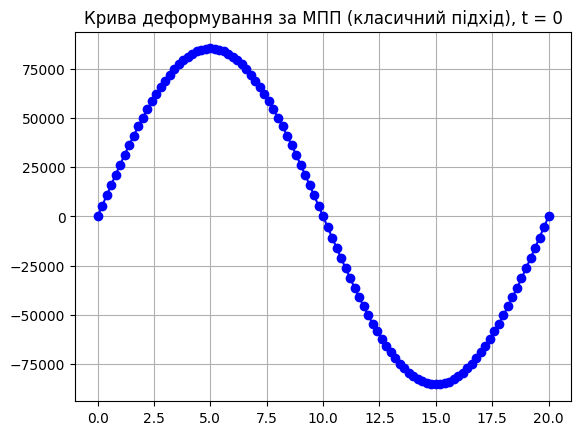

In [170]:
eta = 0.8*0.0987
w = 0.0987
varphi = np.sqrt(w)

A, B = define_inhomogeneous_matrices(varphi)
A_inv = np.linalg.inv(A)
X = np.dot(A_inv,B)

step = 0.2
S = np.arange(0, 2*L+step/2, step)

W_tmm_classic_t = []
for t in [0]:
    W_t = []
    for s in S:
        if s <= L/2:
            W_t.append((X[1]*Krylov(2,varphi,s) + X[3]*Krylov(4,varphi,s)) * np.cos(eta*t))
        if L/2 < s <= L:
            W_t.append((X[1]*Krylov(2,varphi,s) + X[3]*Krylov(4,varphi,s) - Krylov(4,varphi,s-L/2)) * np.cos(eta*t))
        if s > L:
            W_t.append((X[9]*Krylov(2,varphi,s-L) + X[10]*Krylov(3,varphi,s-L) + X[11]*Krylov(4,varphi,s-L)) * np.cos(eta*t))
    
    plt.plot(S, W_t, marker="o", color="blue")
    W_tmm_classic_t.append(copy.deepcopy(W_t))

plt.title(f"Крива деформування за МПП (класичний підхід), t = {0}")
plt.grid()
plt.show()

#### МПП (розклад за власними формами)

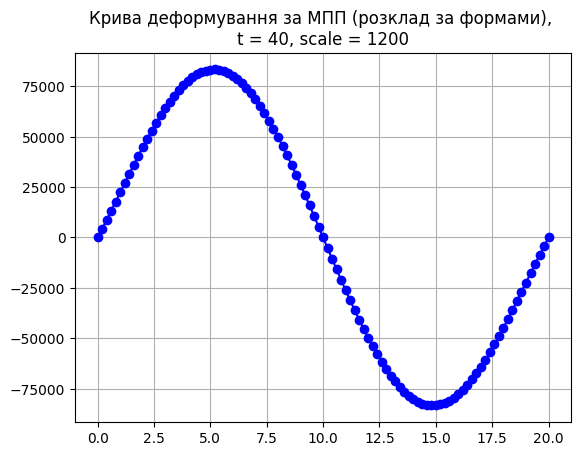

In [171]:
eta = 0.8*0.0987

scale = 1200

step = 0.2
S = np.arange(0, 2*L+step/2, step)

W_tmm_eigenvectors_t = []
for t in [40]:
    W_t = np.zeros(len(S))
    for i in range(len(S)):
        if 0 <= s <= L:
            for w_i in tmm_w[0:5]:
                varphi = np.sqrt(w_i)
                W_t[i] += scale*F(S[i],1,varphi)*T(t,1,w_i,eta)
        if L < s <= 2*L:
            for w_i in tmm_w[0:5]:
                varphi = np.sqrt(w_i)
                W_t[i] += scale*F(S[i]-L,1,varphi)*T(t,1,w_i,eta)
        
    plt.plot(S, W_t, marker="o", color="blue")
    W_tmm_eigenvectors_t.append(copy.deepcopy(W_t))

plt.title(f"Крива деформування за МПП (розклад за формами), \nt = {40}, scale = {scale}")
plt.grid()
plt.show()

#### МЗЗ

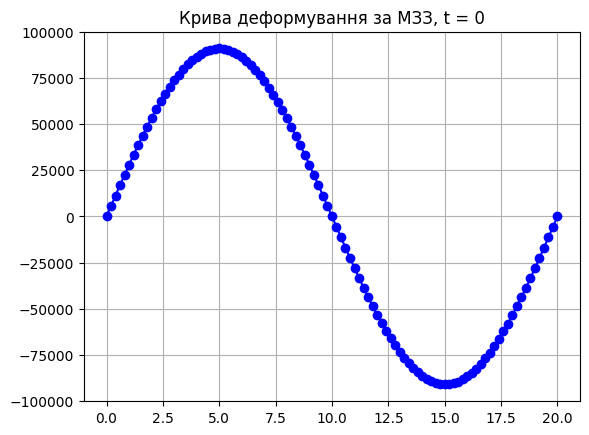

In [172]:
eta = 0.8*0.0987
w = 0.0987
varphi = np.sqrt(w)

I = calculate_integrads(w)

U = np.array([
    [I[1][1], I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
    [I[1][2], I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
    [I[1][3], I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
    [I[1][4], I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
    [I[1][5], I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
    [phi_1(L), phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0],
])

W_wrm_t = []
for t in [0]:
    V = np.array([
        phi_1(L/2)*np.cos(eta*t) / np.cos(w*t), 
        phi_2(L/2)*np.cos(eta*t) / np.cos(w*t),
        phi_3(L/2)*np.cos(eta*t) / np.cos(w*t),
        phi_4(L/2)*np.cos(eta*t) / np.cos(w*t),
        phi_5(L/2)*np.cos(eta*t) / np.cos(w*t),
        0
    ])

    U_inv = np.linalg.inv(U)
    alpha1, alpha2, alpha3, alpha4, alpha5, Z = np.dot(U_inv,V)

    step = 0.2
    S = np.arange(0, 2*L+step/2, step)
    W_t = [alpha1*phi_1(s) + alpha2*phi_2(s) + alpha3*phi_3(s) + alpha4*phi_4(s) + alpha5*phi_5(s) for s in S]
        
    plt.plot(S, W_t, marker="o", color="blue")
    W_wrm_t.append(copy.deepcopy(W_t))

plt.title(f"Крива деформування за МЗЗ, t = {0}")
plt.grid()
plt.show()

### Порівняльний графік

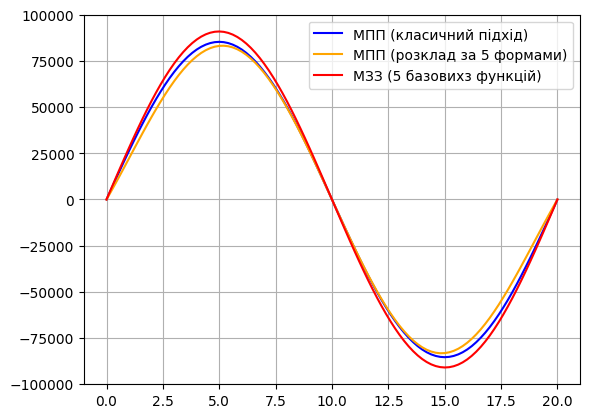

In [173]:
plt.plot(S, W_tmm_classic_t[0], color="blue")
plt.plot(S, W_tmm_eigenvectors_t[0], color="orange")
plt.plot(S, W_wrm_t[0], color="red")

plt.legend(["МПП (класичний підхід)", "МПП (розклад за 5 формами)", "МЗЗ (5 базовихз функцій)"])

plt.grid()
plt.show()

In [ ]:
# print("s W_tmm_classic_t W_tmm_eigenvectors_t W_wrm_t")
# for i in range(len(S)):
#     print(S[i], W_tmm_classic_t[0][i], W_tmm_eigenvectors_t[0][i], W_wrm_t[0][i])